# Surface Event Pick Time

This is a modified version of the surface-event location+directivity analysis that Francesca Skene ( fskene@uw.edu), originally created by her in 7/22/22, who started as an undergraduate student at UW. This is marine denolle's version. It includes:
* Waveform download for each event on each volcano given the PNSN pick times of "su" events.
* Data pre-processing to trim the data within 2-12 Hz and remove outliers.
* phase picking using transfer-learned model (Ni et al, 2023)
* event location using 1D grid search
* directivity measurements (velocity and direction) using Doppler effects.
* gathering of the data into a CSV data frame.

Updated 04/25/2024
Marine Denolle
(mdenolle@uw.edu)

Import Modules

In [66]:
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client

import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from datetime import datetime
from utils import *
from mbf_elep_func import *
import torch
plt.rcParams.update({'font.size': 10})


import seisbench.models as sbm
device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
# from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

from joblib import Parallel, delayed
from matplotlib.backends.backend_pdf import PdfPages
import pyproj

In [67]:
import math
# Calculate the azimuth between the stations and the source location
def calculate_azimuth(row): #source_lat,source_lon,station_lat,station_lon):
    station_location = math.radians(row['lats']), math.radians(row['lons'])
    source_location = math.radians(row['lat_best']), math.radians(row['lon_best'])
    source_location_rad = (math.radians(source_location[0]), math.radians(source_location[1]))
    
    delta_lon = station_location[1] - source_location_rad[1]
    
    numerator = math.sin(delta_lon) * math.cos(station_location[0])
    denominator = math.cos(source_location_rad[0]) * math.sin(station_location[0]) - math.sin(source_location_rad[0]) * math.cos(station_location[0]) * math.cos(delta_lon)
    
    azimuth = math.atan2(numerator, denominator)
    azimuth = math.degrees(azimuth)
     
    # Convert azimuth to range [0, 360]
    # if azimuth < 0:
    #     azimuth += 360
    
    return azimuth# Assume source_location is a tuple (latitude, longitude)



What avalanche are we studying?

In [68]:
ava = 'Avalanche_05282023'

Parameters

In [69]:
# define clients to download the station data
# client = WaveformClient() # we ignore PNWdatastore for now
client2 = Client('IRIS') # IRIS client

t_before = 15 #number of seconds before pick time
# t_after = 15 #number of seconds after pick time
t_before_raw = 1200 #number of seconds before pick time before removing instrumental response
# t_after_raw = 1200 #number of seconds after pick time before removing instrumental response
fs = 40 #sampling rate that all waveforms are resampled to
window = 150 #window length of the signal (this will help with phase picking with EqT next). 
# Use 150 seconds @ 40 Hz gives 6001 points. 
pr = 98 #percentile
thr = 7 #SNR threshold
station_distance_threshold = 25
pi = np.pi
vs = 2800 #shear wave velocity at the surface

# range of dates that we are looking at
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2024,1,1,23,59)

smooth_length = 20 # constant for smoothing the waveform envelopes
low_cut = 1 #low frequency threshold
high_cut = 15 #high frequency threshold
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196 #used to define the grid 
# colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3 # radius of the earth

## Volcano - Station Information

In [70]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('../data/station/Volcano_Metadata_50km.csv')

In [71]:

import rasterio
from matplotlib.colors import LightSource
from rasterio.warp import transform_bounds,  reproject, Resampling , calculate_default_transform
from rasterio.transform import array_bounds

In [72]:
associated_volcano = 'Mt_Rainier'
        
#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()


In [73]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5]
#Find the lower left corner and grid size based on volcano elevation
# define grid origin in lat,lon and grid dimensions in m
lon_start = -121.9 #volc_lat_lon[associated_volcano][0]
lon_end = -121.65 #volc_lat_lon[associated_volcano][0]
lat_start = 46.6 #volc_lat_lon[associated_volcano][1]
lat_end = 47 #volc_lat_lon[associated_volcano][1]


# Create a light source
ls = LightSource(azdeg=315, altdeg=45)


# Load the DEM with rasterio
with rasterio.open('../data/geospatial/Mt_Rainier/Mt_Rainier.tif') as src:
    dem = src.read(1)  # read the first band
    transform = src.transform
    bounds = src.bounds
    crs=src.crs
    # dem = dem.astype('float64')
    dem[dem == -32767] = np.nan #gets rid of edge effects
    # dem = np.nan_to_num(dem,nan=1000)


# Define the target CRS
epsg_code = 32600 + 10
# dst_crs = 'EPSG:4326'  # EPSG:4326 is the code for WGS84 lat/lon
dst_crs = 'epsg:{}'.format(epsg_code) #pyproj.Proj(init=)
# Calculate the transform and dimensions for the reprojected DEM
transform_latlon, width, height = calculate_default_transform(crs, dst_crs, dem.shape[1], dem.shape[0], *bounds)


# Create an empty array for the reprojected DEM
dem_latlon = np.empty(shape=(height, width))

# Reproject the DEM
reproject(
    source=dem,
    destination=dem_latlon,
    src_transform=transform,
    src_crs=crs,
    dst_transform=transform_latlon,
    dst_crs=dst_crs,
    resampling=Resampling.nearest)

# Transform the bounds to the target CRS
left, bottom, right, top = transform_bounds(crs, dst_crs, *bounds)

# Calculate the illumination intensity
illumination = ls.hillshade(dem_latlon)
# new bounds
left, bottom, right, top = array_bounds(height, width, transform_latlon)

In [74]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5]
#Find the lower left corner and grid size based on volcano elevation
# define grid origin in lat,lon and grid dimensions in m
lon_start = -122 #volc_lat_lon[associated_volcano][0]
lon_end = -121.5 #volc_lat_lon[associated_volcano][0]
lat_start = 46.6 #volc_lat_lon[associated_volcano][1]
lat_end = 47 #volc_lat_lon[associated_volcano][1]


proj = pyproj.Proj(proj='utm', zone=10, ellps='WGS84')
if lon_start<0: 
    lon_start1 = lon_start+360
    lon_end1 = lon_end + 360
# Convert lat/long to Cartesian in meters
x_step=100
x1,y1=proj(lon_start,lat_start)
x2,y2=proj(lon_end,lat_end)
# Generate the x and y coordinates for the grid
x_coords = np.arange(x1, x2, x_step)
y_coords = np.arange(y1, y2, x_step)


cmap1 = plt.get_cmap('hot_r')
cmap2 = plt.get_cmap('hsv')


## Event location

In [75]:
dff=pd.read_csv('../data/events/catalog_all_rainier.csv')

### Volcano data



In [76]:

associated_volcano == 'Mt_Rainier'
        
#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

############ LOCATION ############################
# input necessary data for grid search
arrivals = dff['smb_peak'].values
# arrivals = dff[dff['event_ID']==event_ID]['smb_peak'].values
sta_lats = dff['lats'].values
sta_lons = dff['lons'].values


In [77]:
import pyproj


# Define the projection: UTM zone 11 for Washington state
proj = pyproj.Proj(proj='utm', zone=10, ellps='WGS84')

# Convert lat/long to Cartesian in meters
xsta, ysta = proj(sta_lons, sta_lats)
new_xsta =( xsta - np.min(xsta))/1E3
new_ysta = (ysta - np.min(ysta))/1E3

# cmap = plt.get_cmap('hot_r')
# ista=np.where(arrivals>0)[0]
# imin = np.argmin(arrivals[ista])
# for i in ista:
#     tt = arrivals[i]-np.min(arrivals[ista])
#     nmax=np.max(arrivals[ista])-np.min(arrivals[ista])
#     plt.plot(new_xsta[i],new_ysta[i],'o',color=cmap(tt/nmax),markersize=10,markeredgecolor='k')
#     plt.text(new_xsta[i],new_ysta[i],stas[i]+":"+str(np.ceil(tt*10)/10)+" s")
#     plt.axis('equal')
# plt.title("Travel time Relative to " + dff['stas'].values[ista[imin]])

Number of picks total

In [78]:
npicks = dff.shape[0]

In [79]:
dff['x_best']=np.zeros(npicks)
dff['y_best']=np.zeros(npicks)
dff['lat_best']=np.zeros(npicks)
dff['lon_best']=np.zeros(npicks)
dff['dist']=np.zeros(npicks)

In [80]:
evt_id  = np.unique(dff['event_ID'].values)

## Locate all of the events!


In [81]:
xxbest=[]
yybest=[]
llatbest=[]
llonbest=[]

# df=[]
for n in range(len(evt_id)):
  # Find rows where column 'column_name' is equal to 'value'
  # if n<4:continue
  arrivals = dff[dff['event_ID']==evt_id[n]]['smb_peak'].values
  ista =np.where(arrivals>-t_before+0.1)[0]
  # if len(ista)<=2:continue


  # location
  rss_mat,t_best,lon_best,lat_best,x_best,y_best,idx_best = gridsearch(lat_start,lon_start,\
                                                lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],arrivals[ista],vs=vs)

  
  xsta, ysta = proj(sta_lons[ista], sta_lats[ista])
  # distances
  dist=[]
  for ista2 in range(len(xsta)):
      crap=np.sqrt( (xsta[ista2] - x_best)**2 + (ysta[ista2] - y_best)**2)
      dist.append(crap[0])


    # Assuming 'indexes' is a boolean Series or list of row indexes
  indexes = dff[dff['event_ID'] == evt_id[n]].index[ista]

  # Fill 'column_name' in rows where 'indexes' is True with 'value'
  dff.loc[indexes, 'x_best'] = x_best*np.ones(len(xsta))
  dff.loc[indexes, 'y_best'] = y_best*np.ones(len(xsta))
  dff.loc[indexes, 'lat_best'] = lat_best*np.ones(len(xsta))
  dff.loc[indexes, 'lon_best'] = lon_best*np.ones(len(xsta))
  dff.loc[indexes, 'dist'] = dist*np.ones(len(xsta))

  # doppler effects

## calculate azimuth

  # Calculate the azimuth between the stations and the source location
  dff['azimuth'] =  dff.apply(calculate_azimuth, axis=1)


  crap = np.zeros(len(xsta))
  crap2 = np.zeros(len(xsta))
  for ista in range(len(xsta)):
      A = dff[dff['event_ID']==evt_id[n]]['MaxD'].values[ista]*1E6
      A2 = dff[dff['event_ID']==evt_id[n]]['MaxEnv'].values[ista]*1E6
      d = dff[dff['event_ID']==evt_id[n]]['dist'].values[ista]/1E3
      crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
      crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44

  print(crap)
  dff.loc[indexes, 'Lm_sta_D'] = crap
  dff.loc[indexes, 'Lm_sta_Env'] = crap2
  dff.loc[indexes, 'Lm_evt_D'] = np.median(crap)
  dff.loc[indexes, 'Lm_evt_Env'] = np.median(crap2)



  #         if not max(smb_peak.shape):continue

  # print(dff.tail())
  # break


  dff.to_csv("../data/events/catalog_all_rainier4.csv",index=False)

  # dff['xsta']=xsta
  # dff['ysta']=ysta
  # dff['xbest']=x_best*np.ones(len(xsta))
  # dff['ybest']=y_best*np.ones(len(xsta))

  # evlon,evlat = proj(x_best,y_best,inverse=True)
  # dff['evlat']=evlat*np.ones(len(xsta))
  # dff['evlon']=evlon*np.ones(len(xsta))

  # dist=[]
  # for ista in range(len(xsta)):
  #     crap=np.sqrt( (xsta[ista] - x_best)**2 + (ysta[ista] - y_best)**2)
  #     dist.append(crap[0])

  # dff['dist']=dist

[-0.23249285  1.64756024  0.46757762  0.63833651 -0.78596011 -1.19687651
 -1.02256202 -0.54522912  2.12122782  1.56687796 -0.35653413]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...  x_best  y_best  \
647     8.950      43.652734  46.941399 -121.670998  ...     0.0     0.0   
648     2.350      43.229247  46.835640 -121.732979  ...     0.0     0.0   
649     3.375      33.731305  46.870831 -121.732307  ...     0.0     0.0   
650     7.600      46.224811  46.819050 -121.842133  ...     0.0     0.0   
651 

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[-0.42499759  1.84202129  0.17551615  0.18315945 -0.88574661 -1.44502837
 -0.45579924        -inf  2.24028764  1.75475586]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...  x_best  y_best  \
647     8.950      43.652734  46.941399 -121.670998  ...     0.0     0.0   
648     2.350      43.229247  46.835640 -121.732979  ...     0.0     0.0   
649     3.375      33.731305  46.870831 -121.732307  ...     0.0     0.0   
650     7.600      46.224811  46.819050 -121.842133  ...     0.0     0.0   
651    17.725   

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[-0.21196648  1.14160309  0.17086746  0.13361102        -inf        -inf
        -inf -0.9525051  -1.32377904  0.84501966]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...  x_best  y_best  \
647     8.950      43.652734  46.941399 -121.670998  ...     0.0     0.0   
648     2.350      43.229247  46.835640 -121.732979  ...     0.0     0.0   
649     3.375      33.731305  46.870831 -121.732307  ...     0.0     0.0   
650     7.600      46.224811  46.819050 -121.842133  ...     0.0     0.0   
651    17.725   

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[-0.67503004  1.66080132  0.08085877  0.02917362 -0.39745051 -0.84518191
 -1.52312645  1.13555293  1.11834588 -0.16058019]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725      38.5638

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
[-0.15820756        -inf        -inf  3.18522406  0.22060405 -0.22420546
 -0.45524502 -1.39622268 -0.15067471 -0.73094788 -0.774318   -0.42483053
 -0.39806636  1.75004565]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
6

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
[ 0.29403102  1.63745331  0.59988382  1.18774884 -1.36921608 -0.73284968
 -0.8784153         -inf  0.30195758        -inf -0.38955566  1.97662553]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.2248

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
grid search failed to converge in the longitude
[       -inf  3.00596586 -0.61292051  1.72477764  1.55102036        -inf
 -0.26435798  1.00006548        -inf  0.13057068  0.94661332 -0.22732991
  0.67462538]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[ 0.15667801  1.13100864  0.21394766 -0.21746651  1.98721401  1.27951744
  0.49285818]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725      38.563862  46.850849 -121.792953  ...  5858

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[-0.19407114  1.13755951 -0.59398305 -0.00937146        -inf -1.63614232
 -1.64550139 -1.28417394        -inf -1.77851644  1.16120422]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725 

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
[ 1.55137307 -0.05516489 -0.77775564  2.85956454        -inf  1.51649392
  0.42420145  0.20828885  1.14175613  0.22292682        -inf -0.31470632
  0.75279138 -0.44249346  0.31067903  1.93348666  1.55698027]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
[0.42793567 1.56728962 0.04765202 1.09256814 0.22091108 2.60606002
 1.87708314 0.41734365]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    1

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[-1.37052686  1.5095265   0.1367339  -1.33934049 -0.91753211        -inf
 -1.10762496  1.93094806  1.18230393]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725      38.563862  46.85084

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[ 0.58479565 -0.60064864 -0.2991219   2.00513332 -0.0963387   0.19950412]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725      38.563862  46.850849 -121.792953  ...  585890.88353   



/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
[0.98365391       -inf]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725      38.563862  46.850849 -121.792953  ...  585890.88353   



/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
[ 0.15877318        -inf -0.59345719 -0.79273761]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725      38.563862  46.850849 -121.7929

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
[-0.03494574  1.34160478 -1.02594233  0.44121173 -0.90566872  2.58208512
  1.11810539  0.1626328   1.81951722]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  5858

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


grid search failed to converge in the origin time
[ 0.46167274 -0.29877683 -0.44845592  2.11682076  0.17486679 -0.30960903]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725      38.563

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[ 0.00761076        -inf  2.14206779 -0.31525772 -0.09738581 -0.72369284
 -1.30777432  0.2764481  -0.9550448  -1.43383585  0.59664172  0.86502681]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
65

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[ 0.6689912   2.79978114  1.18565604 -0.47362865 -1.58730776 -0.05937859
 -0.82651048  0.60913704 -0.59283711  2.50248728  2.47640596  0.59147256]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
65

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


[ 0.73238765  2.52188985  0.72339105  1.57414068 -0.19886887 -0.84145037
  0.53074483        -inf -0.21749962  1.99815656  2.18296083]
     Unnamed: 0                        otime nets  stas        snr  smb_peak  \
647         647  2023-11-23T11:35:23.000000Z   UW   FMW  14.072391     2.050   
648         648  2023-11-23T11:35:23.000000Z   UW   RCM  22.747501    -1.250   
649         649  2023-11-23T11:35:23.000000Z   UW   RCS  21.061983    -1.650   
650         650  2023-11-23T11:35:23.000000Z   UW   RER  11.347490     1.425   
651         651  2023-11-23T11:35:23.000000Z   UW  STAR   9.843714    45.350   

     max_time  centroid_time       lats        lons  ...        x_best  \
647     8.950      43.652734  46.941399 -121.670998  ...  585890.88353   
648     2.350      43.229247  46.835640 -121.732979  ...  585890.88353   
649     3.375      33.731305  46.870831 -121.732307  ...  585890.88353   
650     7.600      46.224811  46.819050 -121.842133  ...  585890.88353   
651    17.725 

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:53: RuntimeWarning: divide by zero encountered in log
  crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_82252/1047386481.py:54: RuntimeWarning: divide by zero encountered in log
  crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44


## Doppler effects?

In [82]:


# ## Fit a doppler function
# # Prepare data
# x_data = np.radians(dff['azimuth'].values[ista])
# y_data = dff['char_freq'].values[ista]

# # Initial guess for the parameters
# initial_guess = [0, 2*np.pi,  0]

# # Fit the function to the data
# params, params_covariance = curve_fit(doppler_func, x_data, y_data, p0=initial_guess)

# print(params)

# az=np.linspace(-np.pi,np.pi,100)
# dop = doppler_func(az,params[0],params[1],params[2])

# # Plot the characteristic frequency as a function of azimuth
# plt.figure(figsize=(10, 6))
# for station in dff['stas'].unique():
#     station_data = dff[dff['stas'] == station]
#     plt.plot(station_data['azimuth'], station_data['char_freq'],'o',markersize=14, label=station)
# plt.plot(np.degrees(az),dop,label='l2')
# plt.xlabel('Azimuth (degrees)')
# plt.ylabel('Characteristic Frequency (Hz)')
# plt.legend(loc='upper right',fontsize=10)
# plt.grid(True)
# plt.show()

In [83]:
# from scipy.optimize import least_squares

# # Define the residuals function
# def residuals_func(params, x_data, y_data,weight):
#     return (y_data - doppler_func(x_data, *params))*weight

# # Initial guess for the parameters
# initial_guess = [0, 2*np.pi,  0]

# # Fit the function to the data using L1 norm minimization
# result = least_squares(residuals_func, initial_guess, args=(x_data, y_data,1/dff['snr'].values[ista]), loss='soft_l1')

# # The optimized parameters are stored in result.x
# params = result.x

# print(params)

# az=np.linspace(-np.pi,np.pi,100)
# dop = doppler_func(az,params[0],params[1],params[2])


# # Fit the function to the data
# params, params_covariance = curve_fit(doppler_func, x_data, y_data, p0=initial_guess,sigma=dff['snr'].values[ista])
# dop2 = doppler_func(az,params[0],params[1],params[2])

# # Plot the characteristic frequency as a function of azimuth
# plt.figure(figsize=(10, 6))
# for station in dff['stas'].unique():
#     station_data = dff[dff['stas'] == station]
#     plt.plot(station_data['azimuth'], station_data['char_freq'],'o',markersize=14, label=station)
# plt.plot(np.degrees(az),dop,label='l2')
# plt.plot(np.degrees(az),dop2,label='l1')
# plt.xlabel('Azimuth (degrees)')
# plt.ylabel('Characteristic Frequency (Hz)')
# plt.legend(loc='upper right',fontsize=10)
# plt.grid(True)
# plt.show()

In [84]:
# if params[0]<0:
#     direction = params[1]+np.pi 
# else:
#     direction = params[1]   
# fmax = max(dop)
# fmin = min(dop)
# v = vs*((fmax-fmin)/(fmax+fmin))
# print(direction,v)


In [85]:
# dff['flow_dir'] = direction
# dff['flow_speed'] = v

## Plot catalog

In [86]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5]
#Find the lower left corner and grid size based on volcano elevation
# define grid origin in lat,lon and grid dimensions in m
lon_start = -122 #volc_lat_lon[associated_volcano][0]
lon_end = -121.5 #volc_lat_lon[associated_volcano][0]
lat_start = 46.6 #volc_lat_lon[associated_volcano][1]
lat_end = 47 #volc_lat_lon[associated_volcano][1]


proj = pyproj.Proj(proj='utm', zone=10, ellps='WGS84')
if lon_start<0: 
    lon_start1 = lon_start+360
    lon_end1 = lon_end + 360
# Convert lat/long to Cartesian in meters
x_step=100
x1,y1=proj(lon_start,lat_start)
x2,y2=proj(lon_end,lat_end)
# Generate the x and y coordinates for the grid
x_coords = np.arange(x1, x2, x_step)
y_coords = np.arange(y1, y2, x_step)


cmap1 = plt.get_cmap('hot_r')
cmap2 = plt.get_cmap('hsv')


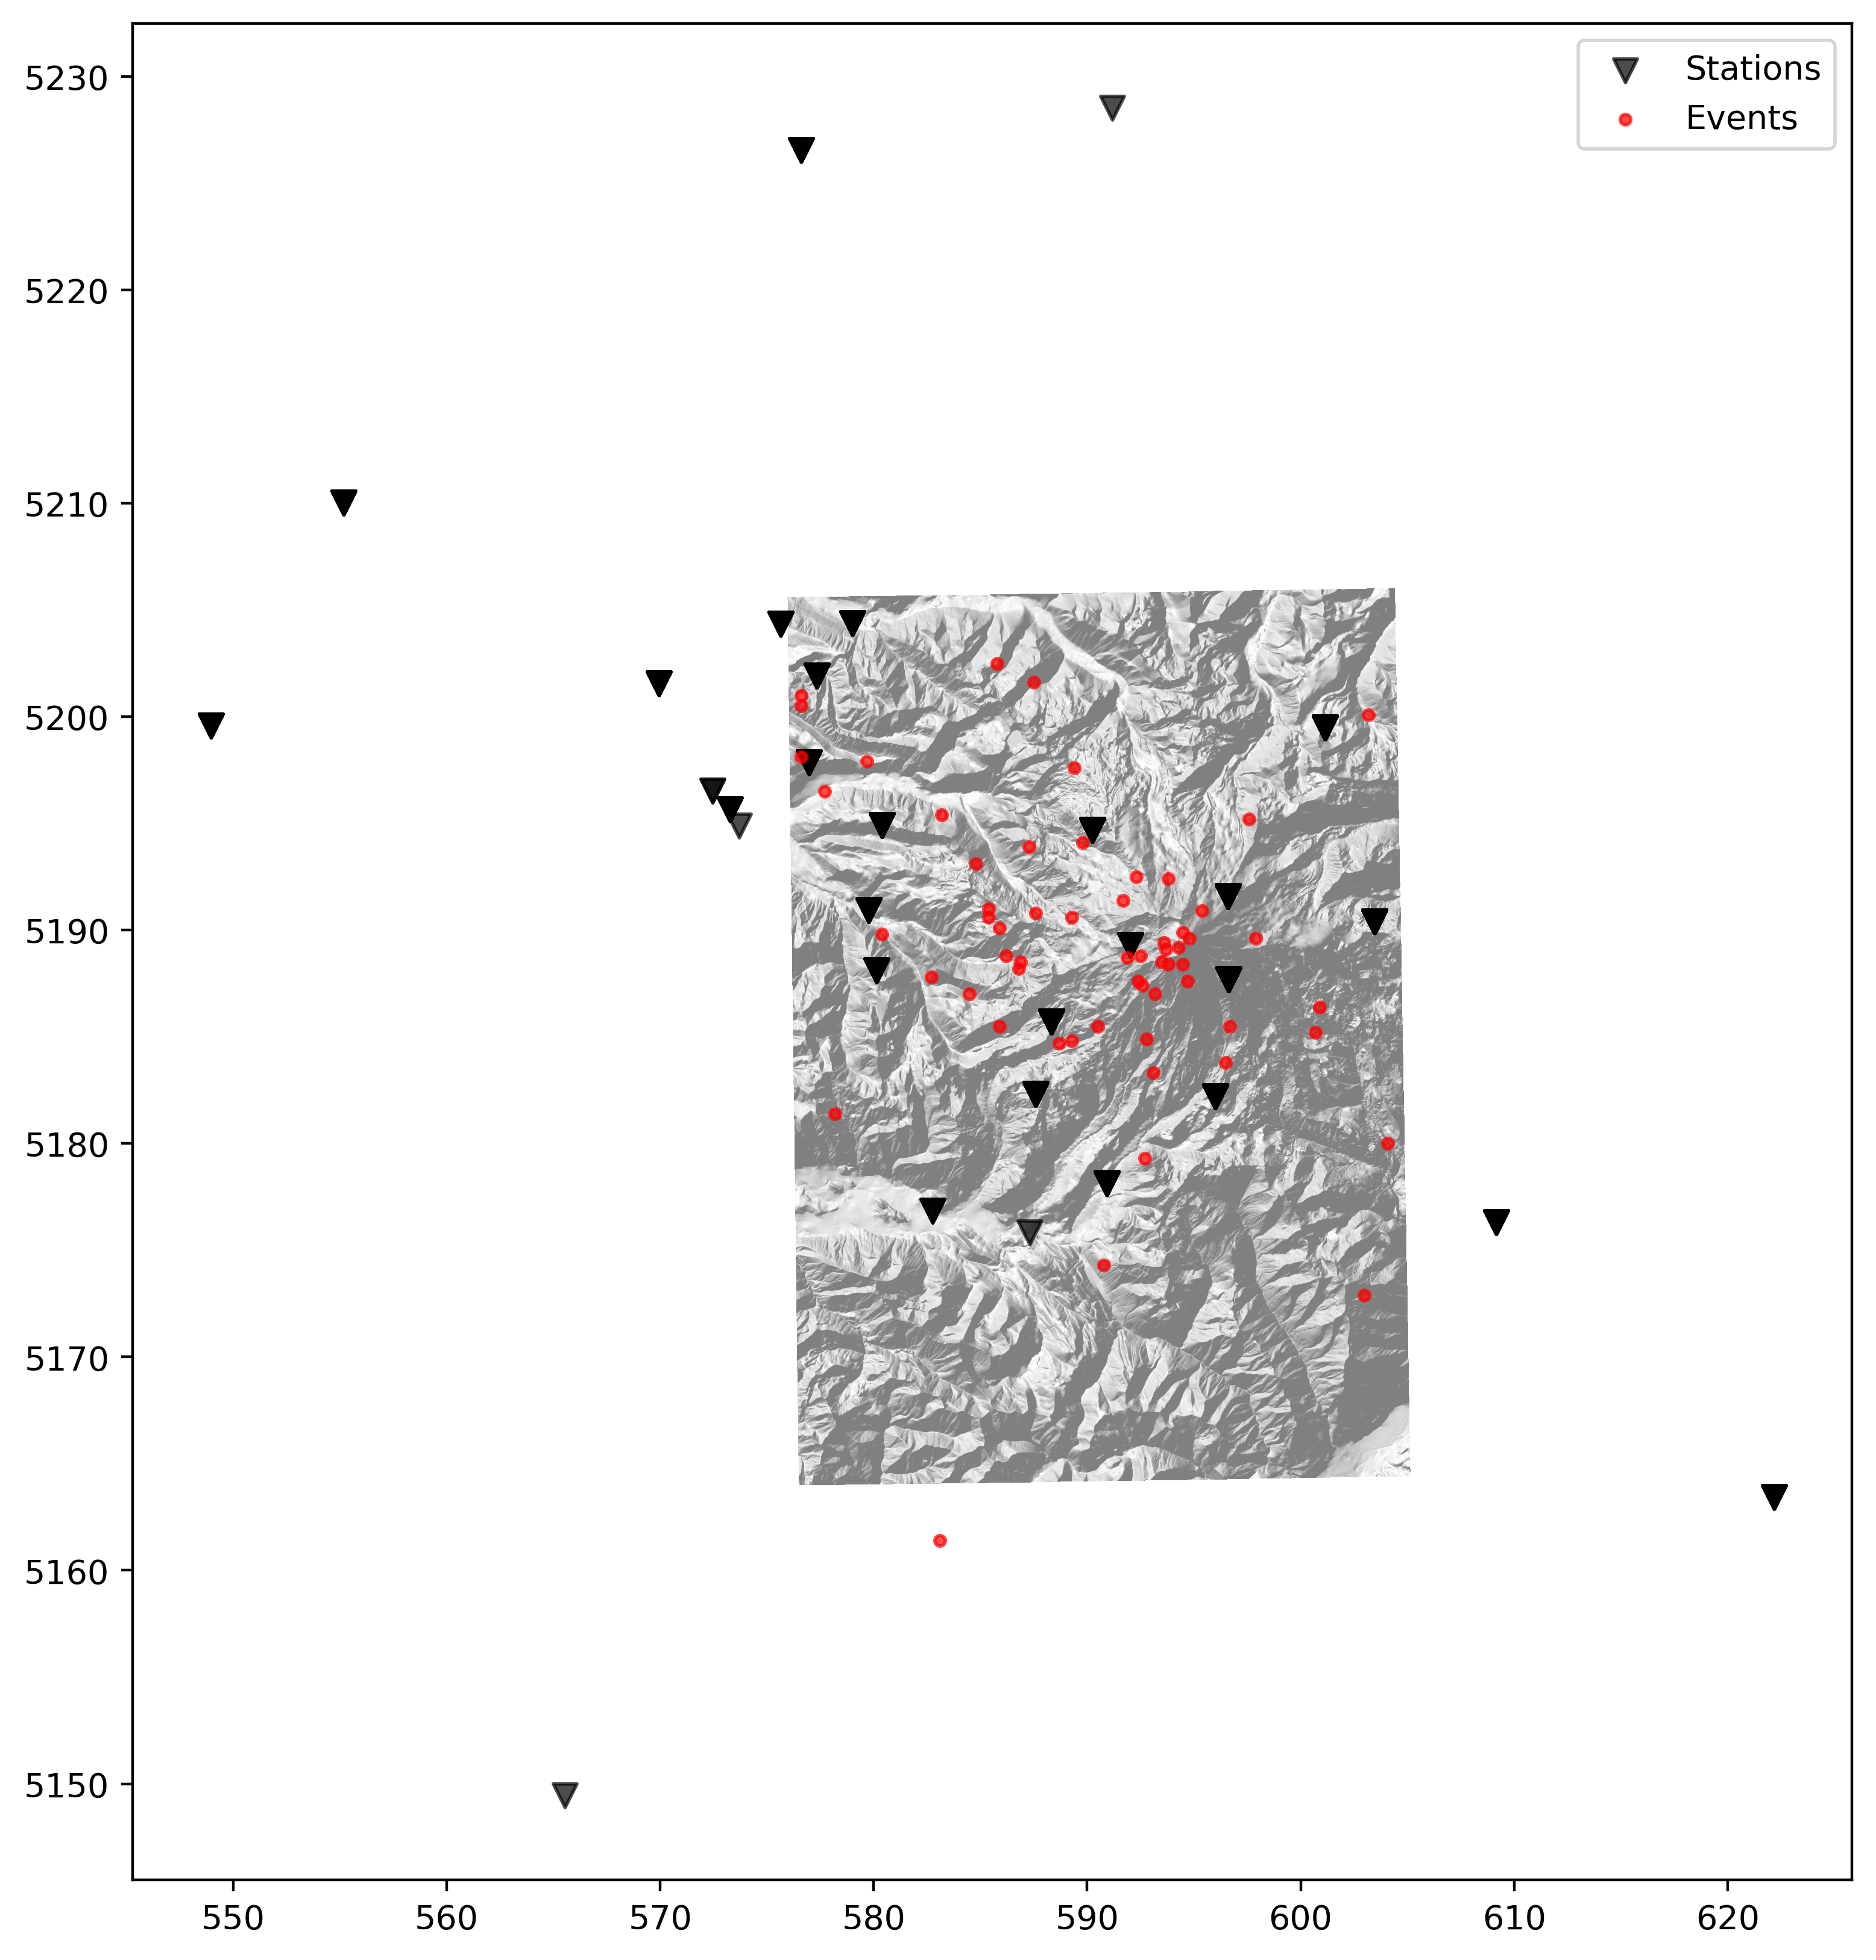

In [87]:

fig, ax = plt.subplots(figsize=(16, 10), dpi=400)

# find the right UTM zone for the data
def get_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1
utm_zone = get_utm_zone(np.mean(sta_lons))
# # Define the projection: UTM zone 11 for Washington state
proj = pyproj.Proj(proj='utm', zone=utm_zone, ellps='WGS84')
# Convert lat/long to Cartesian in meters
xsta, ysta = proj(sta_lons, sta_lats)
cmap = plt.get_cmap('hot_r')

# plt.imshow(illumination, extent=[left/1E3, right/1E3, bottom/1E3,top/1E3 ], cmap='gray',clim=[0,1],alpha=0.5,aspect='equal');
# plt.imshow(illumination, extent=[lon_start, lon_end, lat_start, lat_end], cmap='gray',\
    # clim=[0,1],alpha=0.5,aspect='equal')

# Get unique stations
unique_stations = dff['stas'].unique()

# Get their latitudes and longitudes
unique_lats = dff.loc[dff['stas'].isin(unique_stations), 'lats'].values
unique_lons = dff.loc[dff['stas'].isin(unique_stations), 'lons'].values


unique_events = dff[['x_best', 'y_best']].drop_duplicates()
# Get their x_best, y_best, and Lm_sta_Env values
x_best_unique = unique_events['x_best'].values
y_best_unique = unique_events['y_best'].values
Lm_sta_Env_unique = dff.loc[dff['x_best'].isin(x_best_unique) & dff['y_best'].isin(y_best_unique), 'Lm_sta_Env'].values

Lm_sta_Env_unique_m = Lm_sta_Env_unique - np.min(Lm_sta_Env_unique)

# Convert lat/long to Cartesian in meters
xsta_unique, ysta_unique = proj(unique_lons, unique_lats)

# Plot the unique stations on the map
plt.scatter(xsta_unique/1E3, ysta_unique/1E3, marker='v',color='k', s=50, alpha=0.7, label='Stations')

# Keep the rest of your plot as is
plt.imshow(illumination, extent=[left/1E3, right/1E3, bottom/1E3,top/1E3 ], cmap='gray',clim=[0,1],alpha=0.5,aspect='equal');
# plt.plot(x_best/1E3,y_best/1E3,'o',color='k',markersize=10)


# Plot the unique events on the map with a markersize that scales with Lm_sta_Env
plt.scatter(x_best_unique[x_best_unique>0]/1E3, y_best_unique[x_best_unique>0]/1E3, s=10, color='r', alpha=0.7, label='Events')

# plt.plot(x_best/1E3,y_best/1E3,'o',color='k',markersize=10)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [88]:
Lm_sta_Env_unique_m


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na